In [11]:
using MagneticLaplacianSparsifier
using Graphs, MetaGraphs, Random, IterTools, LinearAlgebra, GraphPlot, Arpack, Plots, SparseArrays
using Statistics
using Measures
using GraphIO 
using ParserCombinator 
using PlotlyJS
using JLD2, DelimitedFiles

<h1>Table of Contents</h1>
<ul>
    <li>
        <a href="#Polblogs"> PolBlogs</a>
    </li>
    <li>
        <a href="#LargeGraphs"> Large Graphs</a>
    </li>
    <ul>
        <li>
            <a href="#Epinions"> Epinions</a>
            <ul>
                <li><a href="#MUNEpinions"> MUN Epinions</a></li>
                <li><a href="#EROEpinions"> ERO Epinions</a></li>
            </ul>
        </li>
        <li>
            <a href="#Stanford"> Stanford</a>
            <ul>
                <li><a href="#MUNStanford"> MUN Stanford</a></li>
                <li><a href="#EROStanford"> ERO Stanford</a></li>
            </ul>
        </li>
    </ul>
</ul>


## PolBlogs graph  <a id="PolBlogs"></a>

In [12]:
splg_methods = [
    "DPP(K) unif",
    "DPP(K) JL-LS",
    #"DPP(K) LS", # requires computing exact leverage scores
    "iid JL-LS",
    #"iid LS", # requires computing exact leverage scores
    "ST JL-LS",
    # "ST LS", # requires computing exact leverage scores
]

# simulation parameters
n_batch = 6; # maximum batch size considered
n_rep = 3; # number of runs

#### Laplacian spectrum

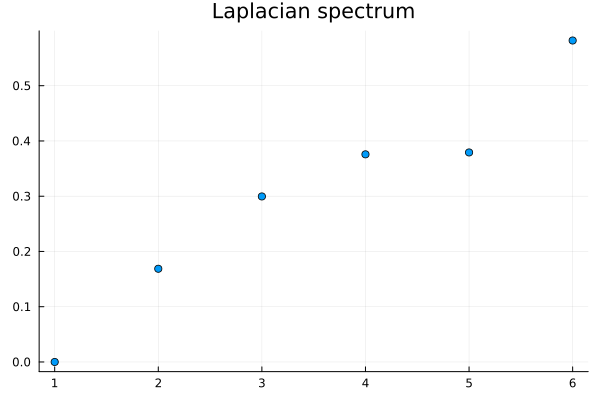

In [13]:
graph_name = "polblogs"
g = loadgraph("polblogs.gml", "digraph", GraphIO.GML.GMLFormat())
g = SimpleGraph(g)

rng = Random.default_rng()

# select largest connected component
temp = connected_components(g)
g = g[temp[1]]

meta_g = MetaGraph(g)
for e in edges(meta_g)
    set_prop!(meta_g, e, :angle, 0.0)
end

### plotting Laplacian spectrum

B = sp_magnetic_incidence(meta_g)
Lap = B' * B
Lap = 0.5 * (Lap + Lap')
least_eigs,_ = eigs(Lap; nev=6, which=:SM)

Plots.scatter(1:6,sort(real.(least_eigs));legend=false,title="Laplacian spectrum")

In [14]:
# regularization parameter
q = 0.01
# storing settings
D_params = Dict("q" => q,"n_batch" => n_batch,"n_rep" => n_rep)
# compute condition numbers
D_results = cond_numbers(meta_g,q,n_batch,n_rep,rng;splg_methods)
name = "precond_"*graph_name*"_"*"q"*string(q)
save("figures/data/"*name*"_data.jld2", "D_results", D_results,"D_params", D_params)

cond nb of Laplacian: 35205.57120411235
k = 

393 vs nb edges= 16717
 
k = 

393 vs nb edges= 16717
 
method: DPP(K) unifmethod: 

DPP(K) JL-LSmethod: 

iid JL-LSmethod: 

ST JL-LS

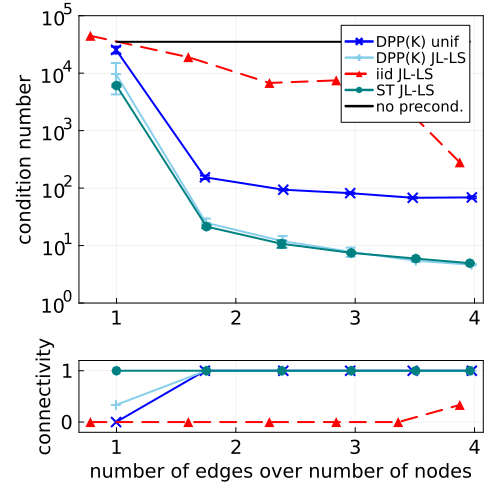

"/Users/mfanuel/Documents/Code/juliaTemplate/MagneticLaplacianSparsifier/notebooks/figures/precond_polblogs_q0.01.pdf"

In [15]:
# loading results
q = 0.01
name = "precond_"*graph_name*"_"*"q"*string(q)
load("figures/data/"*name*"_data.jld2")
# plotting
y_limits = (1,1e5)
plot_comparison_cond(D_results,y_limits;legendposition=:topright,splg_methods)
# saving plot
Plots.savefig("figures/"*name*".pdf")

## Large graphs <a id="LargeGraphs"></a>

For efficiency, we define the following function.

In [16]:
function timing_and_precond(rng,graph_name,type,q,eta,n_rep_time,n_rep_cond,splg_methods)

    if  graph_name == "epinions"
        list = readdlm("soc-Epinions1.txt")
        mist = list .+ 1 # s.t. indices start at 1
        list_tuple = Array(tuple.(eachcol(Int.(list))...))
        e_list = Edge.(list_tuple)
        meta_g = SimpleGraphFromIterator(e_list)
    elseif graph_name == "stanford"
        graph_name = "stanford"
        list = readdlm("web-stanford.txt")
        list_tuple = Array(tuple.(eachcol(Int.(list))...))
        e_list = Edge.(list_tuple)
        meta_g = SimpleGraphFromIterator(e_list)
    elseif graph_name == "pokec"
        list = readdlm("soc-pokec-relationships.txt")
        list = list .+ 1 # s.t. indices start at 1
        list = Array(tuple.(eachcol(Int.(list))...))
        list = Edge.(list)
        meta_g = SimpleGraphFromIterator(list)
    else
        error("graph not known")
    end

    meta_g = main_component(meta_g)
    meta_g = SimpleGraph(meta_g)
    n = nv(meta_g)
    m = ne(meta_g)
    println("n= ",n)
    println("m= ",m)
    
    meta_g = MetaGraph(meta_g)
    if type == "combinatorial"
        for e in edges(meta_g)
            set_prop!(meta_g, e, :angle, 0.0)
        end
        eta = 0
    elseif type == "MUN" || type == "ERO"
        planted_score = randperm(rng,n)
        meta_g = turn_into_connection_graph(rng,meta_g,eta,type,planted_score)
    else
        error("type not known")
    end

    time_crsf = zeros(n_rep_time)
    time_st = zeros(n_rep_time)

    # warm up (precompiling takes time)
    vec_crsf = @timed multi_type_spanning_forest(rng, meta_g, q)
    absorbing_node = true
    ust = true
    weighted = false
    vec_st = @timed multi_type_spanning_forest(rng, meta_g, q; weighted, absorbing_node, ust)

    for i_rep = 1:n_rep_time
        vec_crsf = @timed multi_type_spanning_forest(rng, meta_g, q)
        vec_st = @timed multi_type_spanning_forest(rng, meta_g, q; weighted, absorbing_node, ust)
        time_crsf[i_rep] = vec_crsf[2]
        time_st[i_rep] = vec_st[2]
    end
    if q > 1e-10
        println("mean time CRSF sampling: ", mean(time_crsf))
    else
        println("mean time MTSF sampling: ", mean(time_crsf))
    end
    println("mean time ST sampling: ",mean(time_st))
    
    D_params = Dict("type" => type,"eta" => eta,"n_rep" =>  n_rep_time)
    name = type*"_time_"*graph_name*"_"*"eta"*string(eta)*"q"*string(q)
    file_time = "figures/data/"*name*"_data.jld2"
    save(file_time, "time_crsf", time_crsf,"time_st", time_st ,"D_params", D_params)

    println("times saved in "*file_time)

    # simulation parameters
    n_batch = 3 # maximum number of batches considered

    # storing settings
    D_params = Dict("q" => q,"n_batch" => n_batch,"n_rep" => n_rep_cond)

    # compute condition numbers
    D_results = cond_numbers(meta_g,q,n_batch,n_rep_cond,rng;splg_methods)
    name = type*"precond_"*graph_name*"_"*"q"*string(q)
    file_cond = "figures/data/"*name*"_data.jld2"
    save(file_cond, "D_results", D_results,"D_params", D_params)

    println("cond numbers saved in "*file_cond)

    return file_time,file_cond
end

timing_and_precond (generic function with 1 method)

###  Epinions  <a id="Epinions"></a>

MUN Epinions <a id="MUNEpinions"></a>

In [17]:
graph_name = "epinions"
type = "MUN"
rng = Random.default_rng()

eta = 0.05
q = 0

splg_methods = ["DPP(K) unif","ST unif"]

n_rep_time = 10
n_rep_cond = 1

file_time,file_cond = timing_and_precond(rng,graph_name,type,q,eta,n_rep_time,n_rep_cond,splg_methods)

n= 75869
m= 405057


mean time MTSF sampling: 0.2604282978
mean time ST sampling: 0.608031195
times saved in figures/data/MUN_time_epinions_eta0.05q0_data.jld2


cond nb of Laplacian: 503664.264848208
method: DPP(K) unifmethod: 

ST unifcond numbers saved in figures/data/MUNprecond_epinions_q0_data.jld2

("figures/data/MUN_time_epinions_eta0.05q0_data.jld2", "figures/data/MUNprecond_epinions_q0_data.jld2")

Plotting times

In [18]:
D = load(file_time)
time_crsf = D["time_crsf"]
time_st = D["time_st"]

# cycle-rooted spanning forests
trace_crsf = box(y=time_crsf,
quartilemethod="linear",
name="CRSF",
boxmean=true)

# spanning trees
trace_st = box(y=time_st,
quartilemethod="linear",
name="ST",
boxmean=true)

layout = Layout(
    autosize=false,
    width=500,
    height=500,
    margin=attr(l=1, r=1, b=1, t=1, pad=4),
    font_size=20,
    boxmode="group",
    showlegend=false
)
plt_MUN = PlotlyJS.plot([trace_crsf, trace_st],layout)

name = type*"_time_"*graph_name*"_"*"eta"*string(eta)*"q"*string(q)
PlotlyJS.savefig(plt_MUN,"figures/"*name*".pdf")

"figures/MUN_time_epinions_eta0.05q0.pdf"

plotting condition numbers

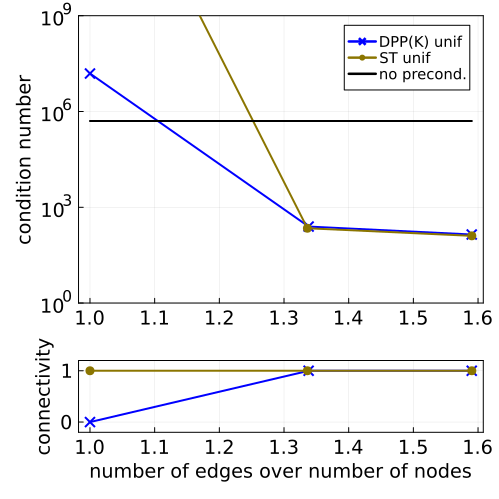

"/Users/mfanuel/Documents/Code/juliaTemplate/MagneticLaplacianSparsifier/notebooks/figures/MUN_cond_epinions_eta0.05q0.pdf"

In [19]:
D = load(file_cond)
D_results = D["D_results"]
# plotting
y_limits = (1,1e9)
plot_comparison_cond(D_results,y_limits;legendposition=:topright,splg_methods)

# saving plot
name = type*"_cond_"*graph_name*"_"*"eta"*string(eta)*"q"*string(q)
Plots.savefig("figures/"*name*".pdf")

ERO Epinions <a id="EROEpinions"></a>

In [20]:
type = "ERO"
graph_name = "epinions"
rng = Random.default_rng()
eta = 2*1e-5
q = 0
splg_methods = ["DPP(K) unif","ST unif"]

n_rep_time = 10
n_rep_cond = 1

file_time_ERO_epinions,file_cond_ERO_epinions = timing_and_precond(rng,graph_name,type,q,eta,n_rep_time,n_rep_cond,splg_methods)

n= 75869
m= 405057


mean time MTSF sampling: 0.48356106069999993
mean time ST sampling: 0.6078452204
times saved in figures/data/ERO_time_epinions_eta2.0e-5q0_data.jld2


cond nb of Laplacian: 1.556713195641782e7
method: DPP(K) unifmethod: 

ST unifcond numbers saved in figures/data/EROprecond_epinions_q0_data.jld2

("figures/data/ERO_time_epinions_eta2.0e-5q0_data.jld2", "figures/data/EROprecond_epinions_q0_data.jld2")

In [21]:
D = load(file_time_ERO_epinions)
time_crsf = D["time_crsf"]
time_st = D["time_st"]

# cycle-rooted spanning forests
trace_crsf = box(y=time_crsf,
quartilemethod="linear",
name="CRSF",
boxmean=true)

# spanning trees
trace_st = box(y=time_st,
quartilemethod="linear",
name="ST",
boxmean=true)

layout = Layout(
    autosize=false,
    width=500,
    height=500,
    margin=attr(l=1, r=1, b=1, t=1, pad=4),
    font_size=20,
    boxmode="group",
    showlegend=false
)
name = type*"_time_"*graph_name*"_"*"eta"*string(eta)*"q"*string(q)
plt_MUN = PlotlyJS.plot([trace_crsf, trace_st],layout)
PlotlyJS.savefig(plt_MUN,"figures/"*name*".pdf")

"figures/ERO_time_epinions_eta2.0e-5q0.pdf"

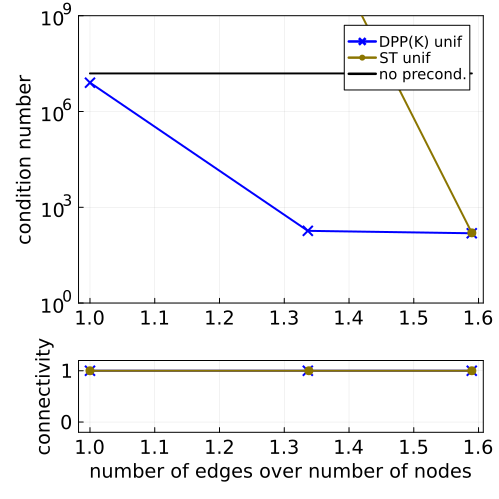

"/Users/mfanuel/Documents/Code/juliaTemplate/MagneticLaplacianSparsifier/notebooks/figures/ERO_cond_epinions_eta2.0e-5q0.pdf"

In [22]:
D = load(file_cond_ERO_epinions)
D_results = D["D_results"]
# plotting
y_limits = (1,1e9)
plot_comparison_cond(D_results,y_limits;legendposition=:topright,splg_methods)

# saving plot
name = type*"_cond_"*graph_name*"_"*"eta"*string(eta)*"q"*string(q)
Plots.savefig("figures/"*name*".pdf")

## Stanford graph  <a id="Stanford"></a>

### MUN Stanford <a id="MUNStanford"></a>

In [23]:
type = "MUN"
graph_name = "stanford"
rng = Random.default_rng()
eta = 0.01
q = 0
splg_methods = ["DPP(K) unif","ST unif"]

n_rep_time = 10
n_rep_cond = 1

file_time_MUN_stanford,file_cond_MUN_stanford = timing_and_precond(rng,graph_name,type,q,eta,n_rep_time,n_rep_cond,splg_methods)

n= 255265
m= 1941926


mean time MTSF sampling: 3.6120142894
mean time ST sampling: 3.9049302364000007
times saved in figures/data/MUN_time_stanford_eta0.01q0_data.jld2


cond nb of Laplacian: 3.6127235661493176e8
method: DPP(K) unifmethod: 

ST unifcond numbers saved in figures/data/MUNprecond_stanford_q0_data.jld2

("figures/data/MUN_time_stanford_eta0.01q0_data.jld2", "figures/data/MUNprecond_stanford_q0_data.jld2")

In [24]:
D = load(file_time_MUN_stanford)
time_crsf = D["time_crsf"]
time_st = D["time_st"]

# cycle-rooted spanning forests
trace_crsf = box(y=time_crsf,
quartilemethod="linear",
name="CRSF",
boxmean=true)

# spanning trees
trace_st = box(y=time_st,
quartilemethod="linear",
name="ST",
boxmean=true)

layout = Layout(
    autosize=false,
    width=500,
    height=500,
    margin=attr(l=1, r=1, b=1, t=1, pad=4),
    font_size=20,
    boxmode="group",
    showlegend=false
)
name = type*"_time_"*graph_name*"_"*"eta"*string(eta)*"q"*string(q)

plt_MUN = PlotlyJS.plot([trace_crsf, trace_st],layout)

PlotlyJS.savefig(plt_MUN,"figures/"*name*".pdf")

"figures/MUN_time_stanford_eta0.01q0.pdf"

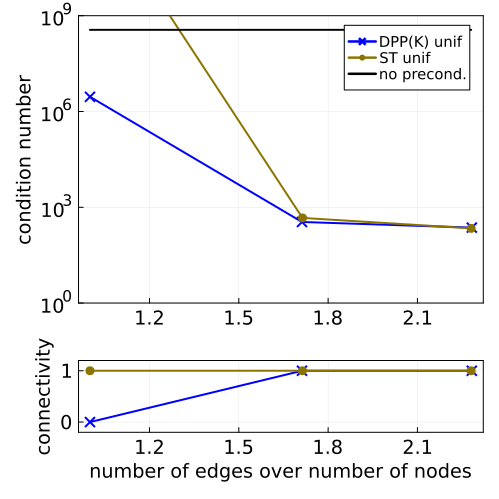

"/Users/mfanuel/Documents/Code/juliaTemplate/MagneticLaplacianSparsifier/notebooks/figures/MUN_cond_stanford_eta0.01q0.pdf"

In [25]:
D = load(file_cond_MUN_stanford)
D_results = D["D_results"]
name = type*"_cond_"*graph_name*"_"*"eta"*string(eta)*"q"*string(q)

# plotting
y_limits = (1,1e9)
plot_comparison_cond(D_results,y_limits;legendposition=:topright,splg_methods)

# saving plot

Plots.savefig("figures/"*name*".pdf")

### ERO Stanford <a id="EROStanford"></a>

In [26]:
type = "ERO"
graph_name = "stanford"
rng = Random.default_rng()
eta = 1.0e-5
q = 0
splg_methods = ["DPP(K) unif","ST unif"]

n_rep_time = 10
n_rep_cond = 1

file_time_ERO_stanford,file_cond_ERO_stanford = timing_and_precond(rng,graph_name,type,q,eta,n_rep_time,n_rep_cond,splg_methods)

n= 255265
m= 1941926


mean time MTSF sampling: 3.3013708401999997
mean time ST sampling: 3.0333806286
times saved in figures/data/ERO_time_stanford_eta1.0e-5q0_data.jld2


cond nb of Laplacian: 4.9993226459870356e8
method: DPP(K) unifmethod: 

ST unifcond numbers saved in figures/data/EROprecond_stanford_q0_data.jld2

("figures/data/ERO_time_stanford_eta1.0e-5q0_data.jld2", "figures/data/EROprecond_stanford_q0_data.jld2")

In [27]:
D = load(file_time_ERO_stanford)
time_crsf = D["time_crsf"]
time_st = D["time_st"]

# cycle-rooted spanning forests
trace_crsf = box(y=time_crsf,
quartilemethod="linear",
name="CRSF",
boxmean=true)

# spanning trees
trace_st = box(y=time_st,
quartilemethod="linear",
name="ST",
boxmean=true)

layout = Layout(
    autosize=false,
    width=500,
    height=500,
    margin=attr(l=1, r=1, b=1, t=1, pad=4),
    font_size=20,
    boxmode="group",
    showlegend=false
)
name = type*"_time_"*graph_name*"_"*"eta"*string(eta)*"q"*string(q)

plt_MUN = PlotlyJS.plot([trace_crsf, trace_st],layout)

PlotlyJS.savefig(plt_MUN,"figures/"*name*".pdf")

"figures/ERO_time_stanford_eta1.0e-5q0.pdf"

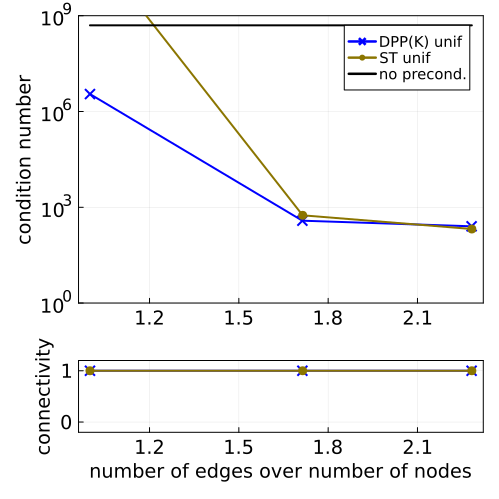

"/Users/mfanuel/Documents/Code/juliaTemplate/MagneticLaplacianSparsifier/notebooks/figures/ERO_cond_stanford_eta1.0e-5q0.pdf"

In [28]:
D = load(file_cond_ERO_stanford)
D_results = D["D_results"]
name = type*"_cond_"*graph_name*"_"*"eta"*string(eta)*"q"*string(q)

# plotting
y_limits = (1,1e9)
plot_comparison_cond(D_results,y_limits;legendposition=:topright,splg_methods)

# saving plot
Plots.savefig("figures/"*name*".pdf")

pokec

In [29]:
# pokec_time_epinions_eta0q0.1_data.jld2

# D = load("pokec_time_epinions_eta0q0.1_data.jld2")
# time_crsf = D["time_crsf"]
# time_st = D["time_st"]

# # cycle-rooted spanning forests
# trace_crsf = box(y=time_crsf,
# quartilemethod="linear",
# name="CRSF",
# boxmean=true)

# # spanning trees
# trace_st = box(y=time_st,
# quartilemethod="linear",
# name="ST",
# boxmean=true)

# layout = Layout(
#     autosize=false,
#     width=500,
#     height=500,
#     margin=attr(l=1, r=1, b=1, t=1, pad=4),
#     font_size=20,
#     boxmode="group",
#     showlegend=false
# )
# name = type*"_time_"*graph_name*"_"*"eta"*string(eta)*"q"*string(q)

# plt_MUN = PlotlyJS.plot([trace_crsf, trace_st],layout)

# PlotlyJS.savefig(plt_MUN,"figures/"*name*".pdf")

ErrorException: syntax: extra token "0.1" after end of expression

In [30]:
# type = "combinatorial"
# graph_name = "pokec"
# rng = Random.default_rng()
# eta = 0
# q = 0.1
# splg_methods = ["DPP(K) unif","ST unif"]

# n_rep_time = 1
# n_rep_cond = 1

# file_time,file_comb = timing_and_precond(rng,graph_name,type,q,eta,n_rep_time,n_rep_cond,splg_methods)